In [ ]:
#code to make a nice plot that shows total storm rainfall across an area of interest, with landslide incident points overlaid
#Points can be changed to any lat/lon point, these are for my specific application
#Thanks to Katy Hollinger for the 'NWS precip colors' colorbar

In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pygrib
import pyproj

from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from matplotlib.colors import TwoSlopeNorm

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel,ll_to_xy, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
import glob

In [2]:
# Set up for saving graphics files, create directory for plots, if needed
plotsdir = '/home/jupyter-amsinnin@ncsu.edu/Ivan/totalraincomparison'
if os.path.isdir(plotsdir) != 1:
    subprocess.call(["mkdir","-p",plotsdir])
os.chdir(plotsdir)

1
/scratch/amanda/ivan_ensembles/ens1_ivan/hourly_d03_2004-09-18_23:00:00
WRF valid time:  2004-09-18_23


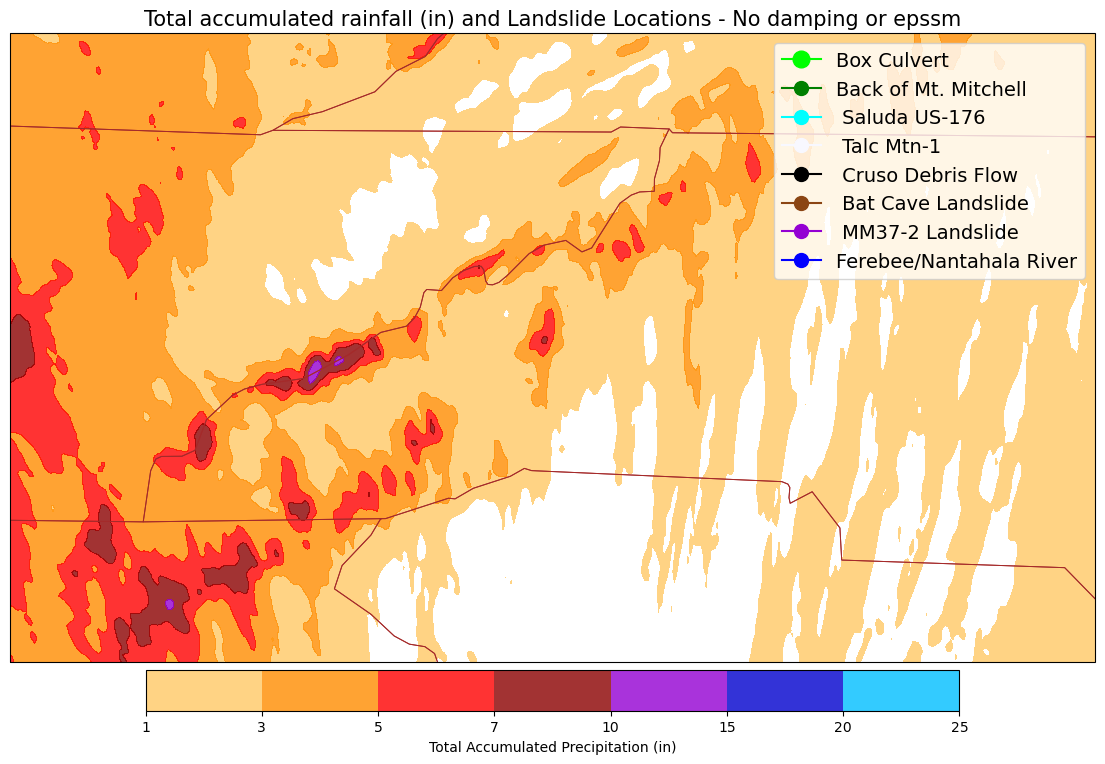

<xarray.DataArray ()>
array(11.769847, dtype=float32)
Coordinates:
    Time     datetime64[ns] 2004-09-18T23:00:06


In [19]:
# SPECIFY Data File

datafiles = (glob.glob("/scratch/amanda/ivan_ensembles/ens1_ivan/hourly_d03_2004-09-18_23:00:00"))
datafiles.sort()
numfiles=len(datafiles)
print(numfiles)
print(datafiles[0])

ivan_rain=[]
ivan_runoff=[]
filetimes=[]
for j in range(0,1):
    ncfile = Dataset(datafiles[j])
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime)

    runoff = ncfile.variables["SFROFF"][0,:,:] #get surface runoff
    z = getvar(ncfile, "z")
    dbz3 =getvar(ncfile, "dbz")
    p = getvar(ncfile, "pressure")
    slp = getvar(ncfile, "slp")
    rainc = getvar(ncfile, "RAINC")
    rainnc = getvar(ncfile, "RAINNC")
    tk = getvar(ncfile, "tk")
    ua = getvar(ncfile, "ua", units="kt")
    va = getvar(ncfile, "va", units="kt")
    wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]
    lat = ncfile.variables['XLAT'][0,:,:]
    lon = ncfile.variables['XLONG'][0,:,:]
    hires_terr= ncfile.variables["HGT"][0,:,:] #terrain height for the 30s terr resolution
    
    raintot = (rainc + rainnc)*0.0393701 #in inches
    
    ivan_rain.append(raintot)
    ivan_runoff.append(runoff)
    filetimes.append(filetime)

    plotproj = crs.Mercator()
    fig = plt.figure(figsize=(14,10))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-85, -79.5, 34.4, 37],crs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.7, edgecolor='brown')
    ax.coastlines('50m', linewidth=0.4)
    
    rain_levels = np.arange(1, 8, 0.5)
    
    plt.plot(-83.6443, 35.3089 , marker= 'o', color='lime', markersize=12, label= 'Box Culvert') #box culvert pt location
    plt.plot(-82.317897,35.829761, marker= 'o', color='green', markersize=10, label = 'Back of Mt. Mitchell') #watershed on back of mt mitchell
    plt.plot(-82.2671,35.2233, marker= 'o', color='aqua', markersize=10, label= ' Saluda US-176') #pigeon river-cruso
    plt.plot(-83.6364,35.3173, marker= 'o', color='ghostwhite', markersize=10, label= ' Talc Mtn-1')
    plt.plot(-82.8139,35.4149, marker= 'o', color='black', markersize=10, label= ' Cruso Debris Flow') 
    plt.plot(-82.2906,35.4493, marker= 'o', color='saddlebrown', markersize=10, label= ' Bat Cave Landslide')
    plt.plot(-82.7745,35.5408, marker= 'o', color='darkviolet', markersize=10, label= ' MM37-2 Landslide')
    # plt.plot(-82.7762,35.5409, marker= 'o', color='gold', markersize=8, label= ' MM37-1 Landslide')
    plt.plot(-83.6535,35.302, marker= 'o', color='blue', markersize=10, label= 'Ferebee/Nantahala River')
    
    clevs = [1, 3, 5, 7, 10, 15, 20, 25]
    nws_precip_colors = [
        "#FFC866",  # 1 - 3 inches
        "darkorange",  # 3 - 5 inches
        "red",  # 5 - 7 inches
        "darkred",  # 7 - 10 inches
        "darkviolet",  # 10 - 15 inches
        "mediumblue",  # 15 - 20 inches
        "deepskyblue",  # 20 - 25 inches
    ]
    cmap = matplotlib.colors.ListedColormap(nws_precip_colors)
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    #co = ax1.contourf(lont, latt, prcpt, clevs, cmap=cmap, norm=norm, transform = ccrs.PlateCarree())

# add colorbar.

    rain_contours = plt.contourf(to_np(lon), to_np(lat), to_np(raintot), levels=clevs,
                             cmap=cmap,norm=norm, alpha=.8,transform=crs.PlateCarree())
    cbar = plt.colorbar(rain_contours, orientation='horizontal', shrink = 0.75, pad=0.01, 
                    label = "Total Accumulated Precipitation (in)")
    
    #now draw avg box overtop of the rain
    #LARGER STRAIGHT BOX
    latminb = 34.9
    latmaxb = 36
    lonminb = -84.2
    lonmaxb = -75

    #larger straight box
    lonn = lon[np.where((lat>latminb) & (lat<latmaxb) & (lon>lonminb) & (lon<lonmaxb))]
    latt = lat[np.where((lat>latminb) & (lat<latmaxb) & (lon>lonminb) & (lon<lonmaxb))]
    
    #the indicies in the polygon function tell where you want the corners to be (0,0 is bottom right, etc)
    # poly = Polygon([(lonn[0],latt[0]),(lonn[0],latt[-1]),(lonn[-1],latt[-1]),(lonn[-1],latt[0])],
    #            facecolor='None', edgecolor='blue',linewidth=4, zorder=2)
    # plt.gca().add_patch(poly)
    plt.legend(fontsize=14)
    plt.title("Total accumulated rainfall (in) and Landslide Locations - No damping or epssm", fontsize =15)
    
    # Create separate plot file and save as .png, then show and close
    plt.savefig('landslidelocs_raintot_plot_hires_'+filetime+'.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
print(np.max(raintot))

1
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-18_23:00:00
WRF valid time:  2004-09-18_23


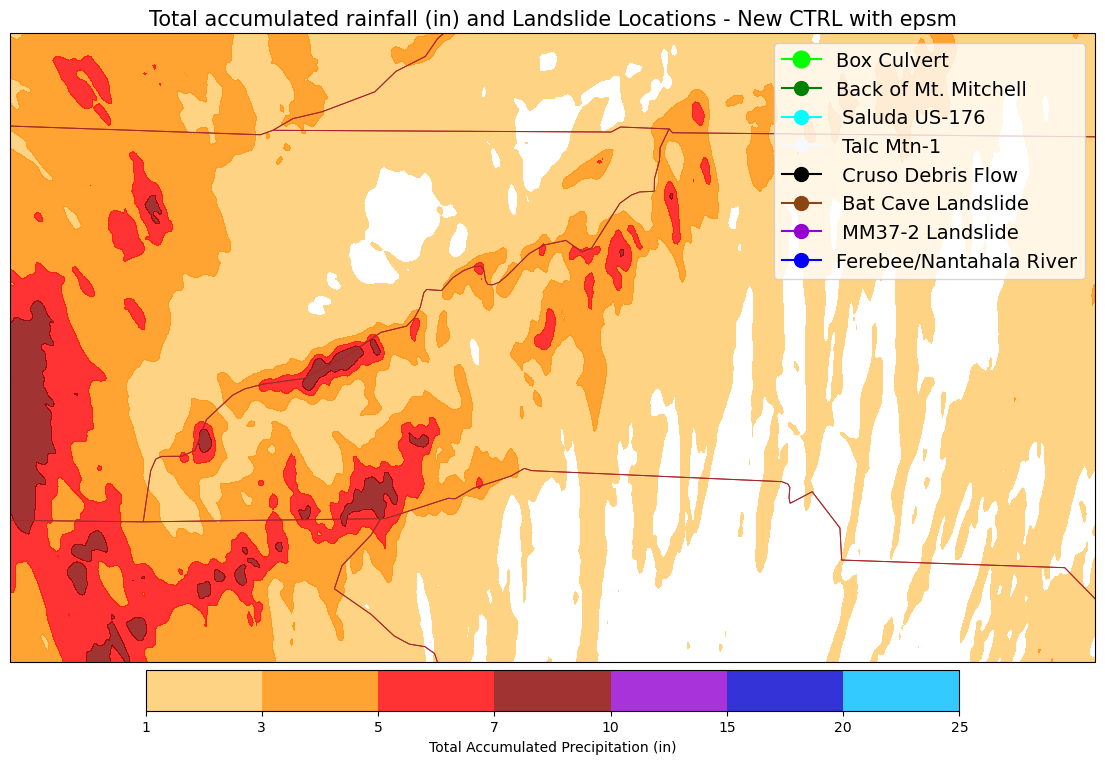

In [18]:
#IF WANT TO COMPARE FILES, INSERT FILE FOR COMPARISON HERE!

datafiles1 = (glob.glob("/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-18_23:00:00"))
datafiles1.sort()
numfiles1=len(datafiles1)
print(numfiles1)
print(datafiles1[0])

ivan_rain1=[]
ivan_runoff1=[]
filetimes1=[]
for j in range(0,1):
    ncfile1 = Dataset(datafiles1[j])
    Time1=wrf.extract_times(ncfile1, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr1=(str(Time1))
    # Set up one time string for plot titles, another for file names
    titletime1=(timestr1[0:10]+' '+timestr1[11:16])
    filetime1=(timestr1[0:10]+'_'+timestr1[11:13])
    print('WRF valid time: ',filetime1)

    runoff1 = ncfile1.variables["SFROFF"][0,:,:] #get surface runoff
    p1 = getvar(ncfile1, "pressure")
    slp1 = getvar(ncfile1, "slp")
    rainc1 = getvar(ncfile1, "RAINC")
    rainnc1 = getvar(ncfile1, "RAINNC")
    mdbz1 = getvar(ncfile1, "mdbz")
    lat1 = getvar(ncfile1, 'lat')
    lon1 = getvar(ncfile1, 'lon')
    hires_terr1= ncfile1.variables["HGT"][0,:,:] #terrain height for the 30s terr resolution

    raintot1 = (rainc1 + rainnc1)*0.0393701 #in inches
    
    ivan_rain1.append(raintot1)
    ivan_runoff1.append(runoff1)
    filetimes1.append(filetime1)
    
    plotproj = crs.Mercator()
    fig = plt.figure(figsize=(14,10))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-85, -79.5, 34.4, 37],crs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.7, edgecolor='brown')
    ax.coastlines('50m', linewidth=0.4)
    
    plt.plot(-83.6443, 35.3089 , marker= 'o', color='lime', markersize=12, label= 'Box Culvert') #box culvert pt location
    plt.plot(-82.317897,35.829761, marker= 'o', color='green', markersize=10, label = 'Back of Mt. Mitchell') #watershed on back of mt mitchell
    plt.plot(-82.2671,35.2233, marker= 'o', color='aqua', markersize=10, label= ' Saluda US-176') #pigeon river-cruso
    plt.plot(-83.6364,35.3173, marker= 'o', color='ghostwhite', markersize=10, label= ' Talc Mtn-1')
    plt.plot(-82.8139,35.4149, marker= 'o', color='black', markersize=10, label= ' Cruso Debris Flow') 
    plt.plot(-82.2906,35.4493, marker= 'o', color='saddlebrown', markersize=10, label= ' Bat Cave Landslide')
    plt.plot(-82.7745,35.5408, marker= 'o', color='darkviolet', markersize=10, label= ' MM37-2 Landslide')
    # plt.plot(-82.7762,35.5409, marker= 'o', color='gold', markersize=8, label= ' MM37-1 Landslide')
    plt.plot(-83.6535,35.302, marker= 'o', color='blue', markersize=10, label= 'Ferebee/Nantahala River')

    rain_contours1 = plt.contourf(to_np(lon), to_np(lat), to_np(raintot1), levels=clevs,
                             cmap=cmap,norm=norm, alpha=.8,transform=crs.PlateCarree())
    cbar = plt.colorbar(rain_contours1, orientation='horizontal', shrink = 0.75, pad=0.01, 
                    label = "Total Accumulated Precipitation (in)") 
    
    #now draw avg box overtop of the rain
    #LARGER STRAIGHT BOX
    latminb = 34.9
    latmaxb = 36
    lonminb = -84.2
    lonmaxb = -75

    #larger straight box
    lonn = lon[np.where((lat>latminb) & (lat<latmaxb) & (lon>lonminb) & (lon<lonmaxb))]
    latt = lat[np.where((lat>latminb) & (lat<latmaxb) & (lon>lonminb) & (lon<lonmaxb))]
    
    #the indicies in the polygon function tell where you want the corners to be (0,0 is bottom right, etc)
    # poly = Polygon([(lonn[0],latt[0]),(lonn[0],latt[-1]),(lonn[-1],latt[-1]),(lonn[-1],latt[0])],
    #            facecolor='None', edgecolor='blue',linewidth=4, zorder=2)
    # plt.gca().add_patch(poly)
    plt.legend(fontsize=14)
    plt.title("Total accumulated rainfall (in) and Landslide Locations - New CTRL with epsm", fontsize =15)
    
    # Create separate plot file and save as .png, then show and close
    plt.savefig('landslidelocs_raintot'+filetime+'.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()


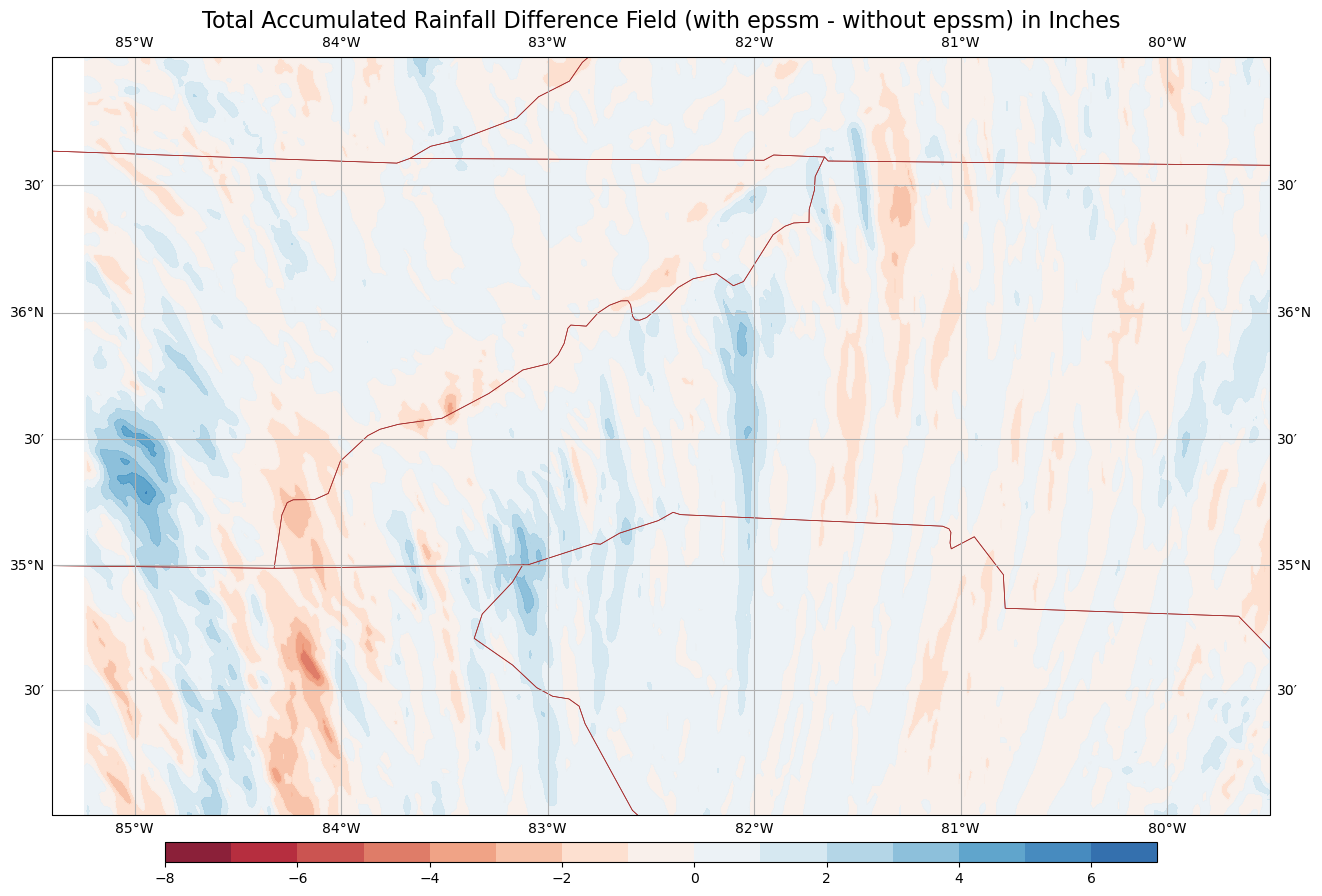

<xarray.DataArray ()>
array(8.403177, dtype=float32) maximum difference in precip
<xarray.DataArray ()>
array(-6.164895, dtype=float32)


In [17]:
#DIFFERENCE FIELD PLOT

plotproj = crs.Mercator()
fig = plt.figure(figsize=(16,12))
ax=plt.subplot(111, projection=plotproj)
ax.set_extent([-85.4, -79.5, 34, 37],crs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.50, edgecolor='brown')
ax.coastlines('50m', linewidth=0.4)

#create difference fields (need to do experiment minus control)
precip_diff = raintot1 - raintot 
#SLP_diff = smooth_slp1 - smooth_slp

#pmsl_levels = np.arange(2, 250, 2)  #(min, max, increment)...decrease min and increment and max to better show SLP difference field

# contours = plt.contour(to_np(lons), to_np(lats), to_np(SLP_diff), levels=pmsl_levels, colors="black", transform=crs.PlateCarree())
# plt.clabel(contours, inline=1, fontsize=10, fmt="%i") 
  
rain_contours = plt.contourf(to_np(lon), to_np(lat), to_np(precip_diff),levels=rain_levels1, norm=Normalize(-8,8),
                             cmap=plt.cm.RdBu, alpha=.9,transform=crs.PlateCarree())
plt.colorbar(rain_contours, ax=ax, orientation="horizontal", pad=.03, shrink=.8, aspect=50)

gridline=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.title("Total Accumulated Rainfall Difference Field (with epssm - without epssm) in Inches", fontsize =16)

outTPlotName= 'terrexp_precipdifferencefield_newcolorbar.png'
plt.savefig(plotsdir+'/'+outTPlotName,dpi=300,bbox_inches="tight")
plt.show()
plt.close()

max_tot_rain=np.max(precip_diff)
print(max_tot_rain,'maximum difference in precip')
mean = np.mean(precip_diff)
print(np.min(precip_diff))